In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from CEC import CEC
import copy

In [4]:
plt.style.use('seaborn')

In [5]:
'''
---- DESCRIPTION ----
Grow a tree to a given height.
state: the current height of the tree. Box(0, height, (1,))
action: the height you want to grow the tree. Box(-0.1, 0.1, (1,))
reward: 1 if the tree is the same/similar height with the given requirement, 0 otherwise.
'''

class GrowingTreeEnv(gym.Env):

    def __init__(self, tree_height=2, init_state=0, max_steps=50):
        self.init_state = np.array([init_state])
        self.goal = tree_height
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-tree_height, high=tree_height, shape=(1,), dtype=np.float32)
        self.seed()
        self.total_steps = 0
        self.max_steps = max_steps

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, a):
        self.total_steps += 1
        self.state = self.state + a
        if np.abs(self.state - self.goal) < 0.1:
            reward = 1
            done = True
        elif self.total_steps >= self.max_steps:
            reward = 0
            done = True
        else:
            reward = 0
            done = False
        return self._get_obs(), reward, done, {}

    def reset(self):
        self.state = self.init_state
        self.total_steps = 0
        return self._get_obs()

    def _get_obs(self):
        return self.state

In [6]:
def render(state):
    plt.figure(figsize=(0.5, 2))
    
    plt.xticks([])
    
    plt.bar(0, state)
    plt.ylim(0, 2)

In [7]:
def evaluate(cec, env):
    states = []
    actions = []
    
    s = env.reset()
    states.append(s)
    done = False
    solved = False
    while not done:
        a, _ = cec.select_action(s, evaluate=True)
        n_s, r, done, _ = env.step(a)
        states.append(n_s)
        actions.append(a)
        s = n_s
    if r == 1:
        solved = True
    return states, actions, solved

In [24]:
def plot_all_states(all_states, eval_actions=None, target=2, steps=10, max_steps=200):
    length = len(all_states)
    nrows = int(length/steps)
    fig, axes = plt.subplots(figsize=(16,8),nrows=nrows, ncols=2)
    idxs = [x * steps for x in range(nrows)]
    
    for n, idx in enumerate(idxs):
        #plt.bar(x=[i for i in range(len(all_states[n]))], height=[s[0] for s in all_states[n]], ax=axes[0,n])
        axes[n][0].bar(x=[i for i in range(len(all_states[idx]))], height=[s[0] for s in all_states[idx]], color='tab:blue')
        axes[n][0].axhline(target, color='tab:red')
        axes[n][0].set_xlim(0, max_steps)
        axes[n][0].set_yticks([])
        axes[n][0].set_xticks([])
        
        if eval_actions[idx] is not None:
            axes[n][1].bar(x=[i for i in range(len(eval_actions[idx]))], height=[a[0] for a in eval_actions[idx]], color='tab:orange')
            axes[n][1].axvline(100, color='tab:red')
            axes[n][1].axhline(0.1, color='tab:green')
            axes[n][1].set_yticks([])
            axes[n][1].set_xticks([])
            axes[n][1].set_ylim(-0.1, 0.1)

In [10]:
max_steps = 100000
total_t = 0
target = 1
env = GrowingTreeEnv(tree_height=target, max_steps=200)
env.reset()
cec = CEC(gamma=0.99, capacity=10000, distance_threshold=0.01, action_space=env.action_space, exploration='random', eps_decay_steps=100000, act_noise=0.1, T=1)
all_states = []
all_actions = []
eval_actions = []
while total_t < max_steps:
    done = False
    eps_s = []
    eps_r = []
    eps_a = []
    s = env.reset()
    while not done:
        a = cec.select_action(s)
        n_s, r, done, _ = env.step(a)
        eps_s.append(s)
        eps_r.append(r)
        eps_a.append(a)
        s = n_s
        total_t += 1
        
        if total_t % 2000 == 0:
            train_env = copy.deepcopy(env)
            states, actions, solved = evaluate(cec, env)
            all_states.append(eps_s)
            all_actions.append(eps_a)
            
            actions = []
            for e_s in np.arange(0, 0.9, 0.01):
                action, _ = cec.select_action(np.array([e_s]), evaluate=True)
                actions.append(action)
            eval_actions.append(actions)
            env = train_env
            #if solved:
            #    print('The task is solved using {} steps'.format(total_t))
            #    break
    cec.update(eps_s, eps_a, eps_r)

The performance drop is because there are more and more new states being added. Previously, coarse solution might work good.

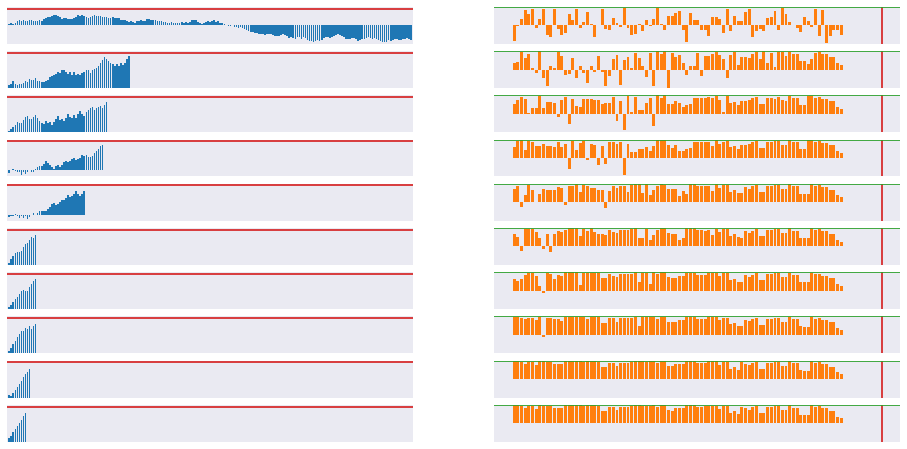

In [25]:
plot_all_states(all_states, steps=5, target=1, eval_actions=eval_actions)

In [273]:
actions = []
for s in np.arange(0, 0.9, 0.01):
    action, _ = cec.select_action(np.array([s]), evaluate=True)
    actions.append(action)

<BarContainer object of 90 artists>

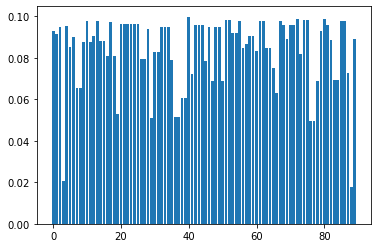

In [274]:
plt.bar(x=[i for i in range(len(actions))], height=[a[0] for a in actions])

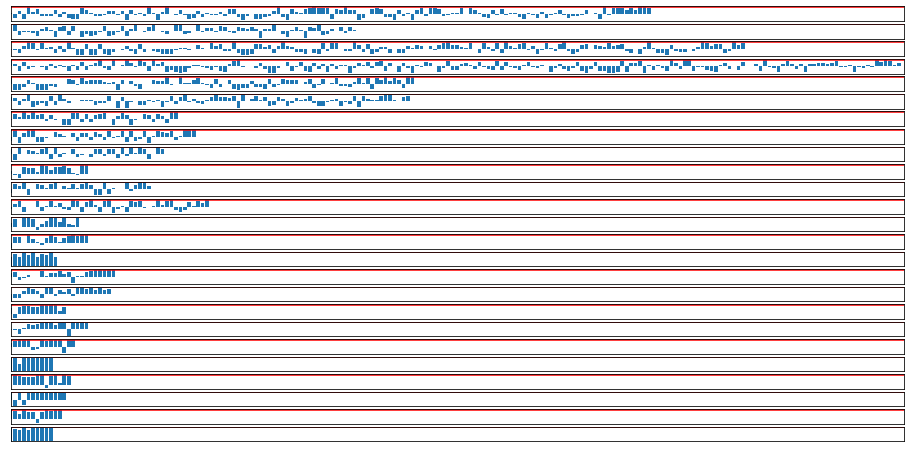

In [271]:
plot_all_states(all_actions, steps=2, target=0.1)

# Restricted Env

In [12]:
'''
---- DESCRIPTION ----
Grow a tree to a given height.
state: the current height of the tree. Box(0, height, (1,))
action: the height you want to grow the tree. Box(-0.1, 0.1, (1,))
reward: 1 if the tree is the same/similar height with the given requirement, 0 otherwise.
'''

class GrowingTreeEnv(gym.Env):

    def __init__(self, tree_height=2, init_state=0, max_steps=50, restrict=-10, action_range=[0.01, 0.02, 0.06, 0.08]):
        self.init_state = np.array([init_state])
        self.goal = tree_height
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-tree_height, high=tree_height, shape=(1,), dtype=np.float32)
        self.seed()
        self.total_steps = 0
        self.max_steps = max_steps
        self.restrict = restrict
        self.action_range = action_range
        self.action_range_n = int(len(self.action_range) / 2)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, a):
        if a >= self.restrict:
            return self._get_obs(), 0, True, {}
        within = False
        for n in range(self.action_range_n):
            if a >= self.action_range[2*n] and a <= self.action_range[2*n+1]:
                within = True
                break
        if not within:
            return self._get_obs(), 0, True, {}
        self.total_steps += 1
        self.state = self.state + a
        if np.abs(self.state - self.goal) < 0.1:
            reward = 1
            done = True
        elif self.total_steps >= self.max_steps:
            reward = 0
            done = True
        else:
            reward = 0
            done = False
        return self._get_obs(), reward, done, {}

    def reset(self):
        self.state = self.init_state
        self.total_steps = 0
        return self._get_obs()

    def _get_obs(self):
        return self.state

In [89]:
max_steps = 100000
total_t = 0
target = 1

env = GrowingTreeEnv(tree_height=target, max_steps=200, restrict=0.1, action_range=[-0.1, 0.1])
env.reset()
cec = CEC(gamma=0.99, capacity=10000, distance_threshold=0.01, action_space=env.action_space, exploration='random', eps_decay_steps=100000, act_noise=0.1, T=1)
all_states = []
all_actions = []
eval_actions = []
while total_t < max_steps:
    done = False
    eps_s = []
    eps_r = []
    eps_a = []
    s = env.reset()
    while not done:
        a = cec.select_action(s)
        n_s, r, done, _ = env.step(a)
        eps_s.append(s)
        eps_r.append(r)
        eps_a.append(a)
        s = n_s
        total_t += 1
        
        if total_t % 2000 == 0:
            train_env = copy.deepcopy(env)
            states, actions, solved = evaluate(cec, env)
            all_states.append(eps_s)
            all_actions.append(eps_a)
            
            actions = []
            for e_s in np.arange(0, 0.9, 0.01):
                action, _ = cec.select_action(np.array([e_s]), evaluate=True)
                actions.append(action)
            eval_actions.append(actions)
            env = train_env
            if solved:
                print('The task is solved using {} steps'.format(total_t))
                raise ValueError('stop')
    cec.update(eps_s, eps_a, eps_r)

The task is solved using 2000 steps


ValueError: stop

### restrict=0.09

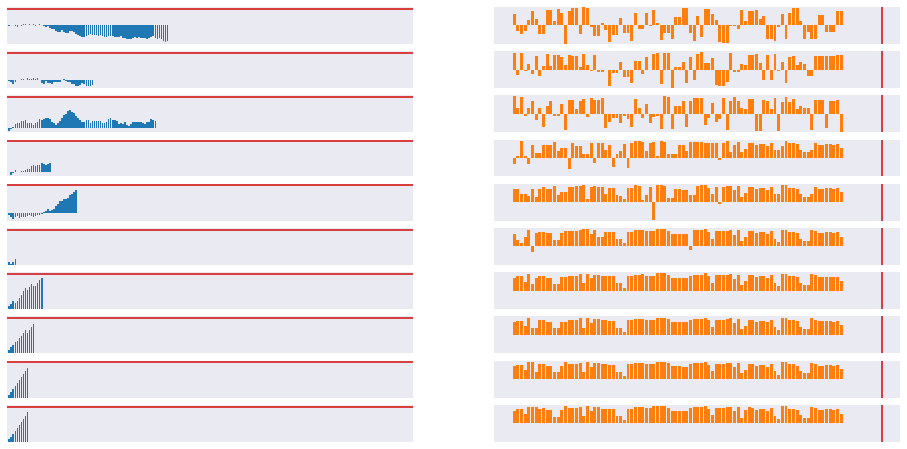

In [58]:
plot_all_states(all_states, steps=5, target=1, eval_actions=eval_actions)

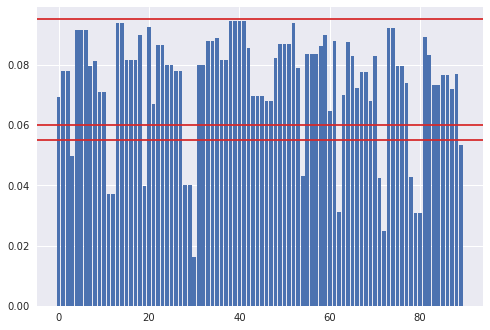

In [59]:
plt.bar(x=[i for i in range(len(eval_actions[-1]))], height=[a[0] for a in eval_actions[-1]])
plt.axhline(y=0.055, color='tab:red')
plt.axhline(y=0.06, color='tab:red')
plt.axhline(y=0.095, color='tab:red')

### Test the CEC agent under different constraints

No restricts: 2000, 2000, 2000, 4000, 2000

restrict > 0.95: 24000, 6000, 4000, 2000, 18000

restrict > 0.95 and invalid [0.55, 0.6]: 8000, 100000, 6000, 14000, 100000

restrict > 0.95 and invalid [0.55, 0.6], [0.8, 0.85]: 6000, 100000, 100000, 100000, 100000

In [90]:
a = [2000, 2000, 2000, 4000, 2000]
b = [24000, 6000, 4000, 2000, 18000]
c = [8000, 100000, 6000, 14000, 100000]
d = [6000, 100000, 100000, 100000, 100000]

Text(0, 0.5, 'Steps needed to solve the task')

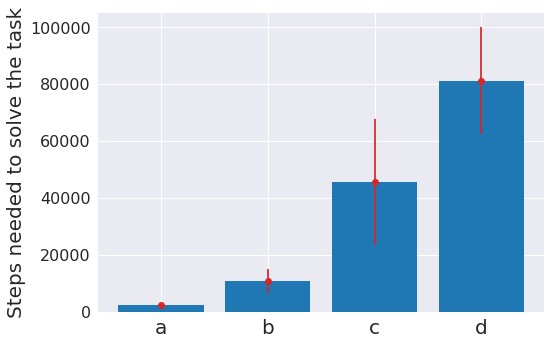

In [122]:
plt.bar(x=[0,1,2,3], height=[np.mean(a), np.mean(b), np.mean(c), np.mean(d)], color='tab:blue')
plt.errorbar(x=[0,1,2,3], y=[np.mean(a), np.mean(b), np.mean(c), np.mean(d)], yerr=[np.std(a)/2, np.std(b)/2, np.std(c)/2, np.std(d)/2], fmt='o', color='tab:red')
# plt.xticks(ticks=[0,1,2,3], labels=['No restriction', 't=0.95', 't=0.95 and A=[0.55:0.6]', 't=0.95 and A=[0.55:0.6, 0.8:0.85]'])
plt.xticks(ticks=[0,1,2,3], labels=['a', 'b', 'c', 'd'], fontsize=20)
plt.yticks(fontsize=16)
plt.ylabel('Steps needed to solve the task', fontsize=20)

In [119]:
np.std(a)/4

200.0